In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [73]:
class Label_generator:
    def __init__(self,path,wsize=30,start=0,stop=None):
        if path.endswith('.csv'):
            self.df=pd.read_csv(path,error_bad_lines=False, low_memory=False)#,dtype={'realtime':'datetime64'})
        elif path.endswith('.hdf'):
            self.df=pd.read_hdf(path,error_bad_lines=False, low_memory=False)#,dtype={'realtime':'datetime64'})
        self.fps=31
        #account for 30FPS
        self.start=start*self.fps
        if stop is None:
            self.stop=self.df.shape[0]
        else:
            self.stop=stop*self.fps
        self.wsize=wsize
        self.df=self.df.iloc[self.start:self.stop]#,self.df.columns!= 'datetime']
        #self._convert_to_unix_time()
        self._bin_preds()
    
    #not needed atm    
#     def _convert_to_unix_time(self):        
#         #unix time in miliseconds
#         newcol = (pd.DatetimeIndex(self.df['realtime'])).astype(np.int64)//10**(6)
#         self.df=self.df.assign(unix_time=newcol)
    
    def _bin_preds(self):
        annot=self.df['Happy_predicted'].values
        #bin s.t. each column is one sec.
        end=annot.shape[0]//self.fps
        self.pred_bin=annot[:self.fps*end].reshape(self.fps,-1)

    #generates labels. Use sliding window if features are also generated with sliding window
    #if a classification method is used, we need a cutoff somewhere :)
    def generate_labels(self,start=0, end=None, mask=None, sliding_window= False,method='ratio', classification=False, cutoff=.07):
        if mask is None:
            print('Warning. No filtering mask for bad data points was given. Assuming perfectly clean dataset.')
            mask=np.zeros(self.pred_bin.shape[1],dtype='bool')
        if end is None:
            end=self.pred_bin.shape[1]-1
        if end >= self.pred_bin.shape[1]:
            end=self.pred_bin.shape[1]-1
            print('Desired window too long. Setting to %d'% end)
        if(method=='ratio'):
            #average "happiness" per second
            happy_portion=np.mean(self.pred_bin,axis=0)
            if(sliding_window):
                self.labels=[]
                time_it=start
                while True:
                    stop=time_it+self.wsize
                    curr_mask=np.ma.compressed(np.ma.masked_array(range(time_it,stop),mask=mask[time_it:stop]))
                    curr_data=happy_portion[curr_mask]
                    if not curr_data.size:
                        time_it+=1
                        if time_it+self.wsize > end:
                            break
                        continue
                    self.labels+=[np.mean(curr_data)]
                    time_it+=1
                    if time_it+self.wsize > end:
                        break
                self.labels=np.array(self.labels)
            else:
                #take average over windows size
                end=(end-start)//self.wsize
                sprt=happy_portion[start:start+end*self.wsize].reshape(self.wsize,-1)
                #before applying mean, take only values that we want in this. use mask for that
                mask=mask[start:start+end*self.wsize].reshape(self.wsize,-1)
                masked_windows=np.ma.array(sprt, mask=mask)
                self.labels=np.ma.compressed(np.ma.mean(masked_windows,axis=0))
        elif method=='median':
            self.labels=[]
            time_it=start
            while True:
                stop=time_it+self.wsize
                curr_mask=np.ma.compressed(np.ma.masked_array(range(time_it,stop),mask=mask[time_it:stop]))
                curr_data=self.pred_bin[:,curr_mask]
                if not curr_data.size:
                    print('A whole batch of labels was thrown away here. Check if this is correct')
                    if (sliding_window):
                        time_it+=1
                    else:
                        time_it+=self.wsize
                    if time_it+self.wsize > end:
                        break
                    continue
                #get rid of NANs
                curr_data=curr_data.flatten()
                curr_data=[c for c in curr_data if c!='N/A']
                med=np.median(np.array(curr_data))
                if med==.5:
                    print(np.array(curr_data).shape)
                    print(curr_data)
                    print(np.median(curr_data))
                    print(np.unique(np.array(curr_data),return_counts=True))
                self.labels+=[med]
                if sliding_window:
                    time_it+=1
                else:
                    time_it+=self.wsize
                if time_it+self.wsize > end:
                    break
            self.labels=np.array(self.labels)
        else:
            raise NameError('The given method does not exist. Try one of the following: ratio,classification.')
        if(classification):
            self.labels[self.labels>cutoff]=1
            self.labels[self.labels<1]=0
            
        return self.labels


In [74]:
test=Label_generator('/home/emil/data/hdf_data/cb46fd46_8_imp_columns.hdf',start=0,stop=32001)

In [75]:
mas=test.generate_labels(method='median')

Warning. No filtering mask for bad data points was given. Assuming perfectly clean dataset.
(458,)
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

In [58]:
np.unique(mas)

array([ 0. ,  0.5,  1. ,  nan])

Text(0,0.5,'time')

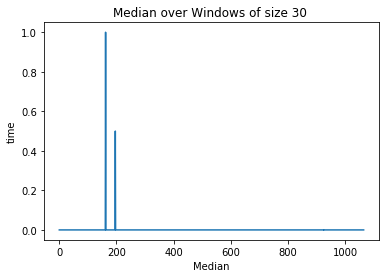

In [77]:
plt.plot(mas)
plt.title('Median over Windows of size %d ' %test.wsize)
plt.xlabel('Median')
plt.ylabel('time')

In [ ]:
#test=Label_generator('/home/emil/data/hdf_data/cb46fd46_8_imp_columns.hdf',start=11,stop=43205)

# mas=test.generate_labels(start=0, end=30000,method='ratio',mask=None)

# # plt.plot(np.mean(test.pred_bin,axis=0))
# # plt.xlabel('sec')
# # plt.ylabel('Happy prediction')


# # plt.plot(test.labels)
# # plt.xlabel('window')
# plt.ylabel('Happy prediction')